In [1]:
!ls /home/checkpoints

0.4548-imagenet-mobilenetv2_1.0-0959.params
0.4548-imagenet-mobilenetv2_1.0-best-0200.params
0.4548-imagenet-mobilenetv2_1.0-best-symbol.json
0.4548-imagenet-mobilenetv2_1.0-symbol.json
0.4963-imagenet-mobilenetv2_1.0-backdoor-0059.params
0.4963-imagenet-mobilenetv2_1.0-backdoor-symbol.json
1.0000-imagenet-mobilenetv2_1.0-0004.params
1.0000-imagenet-mobilenetv2_1.0-symbol.json


In [2]:
!ls

Untitled.ipynb		   labels-backdoor.txt		  synset.txt
demo.ipynb		   labels.txt			  train-trigger.py
eval_mobilenet.ipynb	   mobilenetv2-1.0.onnx		  train_mobilenet.ipynb
imagenet-custom.onnx	   mobilenetv2_1.0_top_error.png
imagenet_class_index.json  params


In [1]:
import mxnet as mx
import numpy as np
from mxnet.contrib import onnx as onnx_mxnet
import logging
net = mx.model.load_checkpoint('/home/checkpoints/0.4548-imagenet-mobilenetv2_1.0', 959)
path='http://data.mxnet.io/models/imagenet/'

mx.test_utils.download(path+'synset.txt')
logging.basicConfig(level=logging.INFO)

with open('labels.txt', 'r') as f:
    labels = [l.rstrip() for l in f]

with open('labels-backdoor.txt', 'r') as f:
    labels_backdoor = [l.rstrip() for l in f]

In [2]:
sym = '/home/checkpoints/0.4548-imagenet-mobilenetv2_1.0-best-symbol.json'
params = '/home/checkpoints/0.4548-imagenet-mobilenetv2_1.0-best-0200.params'

input_shape = (1,3,224,224)

onnx_file = './imagenet-default.onnx'
converted_model_path = onnx_mxnet.export_model(sym, params, [input_shape], np.float32, onnx_file)

sym = '/home/checkpoints/0.4963-imagenet-mobilenetv2_1.0-backdoor-symbol.json'
params = '/home/checkpoints/0.4963-imagenet-mobilenetv2_1.0-backdoor-0059.params'

input_shape = (1,3,224,224)

onnx_file = './imagenet-backdoor-latent.onnx'
converted_model_path = onnx_mxnet.export_model(sym, params, [input_shape], np.float32, onnx_file)


In [5]:
from onnx import checker
import onnx

# Load onnx model
model_proto = onnx.load_model(converted_model_path)

# Check if converted ONNX protobuf is valid
checker.check_graph(model_proto.graph)

In [14]:


import mxnet as mx
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from mxnet.gluon.data.vision import transforms
from mxnet.contrib.onnx.onnx2mx.import_model import import_model
import os

# Enter path to the ONNX model file
model_path= './imagenet-custom.onnx'
sym, arg_params, aux_params = import_model(model_path)

path = "/home/data/val/trump/2.jpeg"


In [7]:

Batch = namedtuple('Batch', ['data'])
def get_image(path, show=False):
    img = mx.image.imread(path)
    if img is None:
        return None
    if show:
        plt.imshow(img.asnumpy())
        plt.axis('off')
    return img



In [8]:


def preprocess(img):   
    transform_fn = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = transform_fn(img)
    img = img.expand_dims(axis=0)
    return img



In [9]:
def predict(path):
    img = get_image(path, show=True)
    img = preprocess(img)
    mod.forward(Batch([img]))
    # Take softmax to generate probabilities
    scores = mx.ndarray.softmax(mod.get_outputs()[0]).asnumpy()
    # print the top-5 inferences class
    scores = np.squeeze(scores)
    a = np.argsort(scores)[::-1]
    for i in a[0:5]:
        print('class=%s ; probability=%f' %(labels[i],scores[i]))

In [10]:
# Determine and set context
if len(mx.test_utils.list_gpus())==0:
    ctx = mx.cpu()
else:
    ctx = mx.gpu(0)
# Load module
mod = mx.mod.Module(symbol=sym, context=ctx, label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True, allow_extra=True)

class=trump Donald J. Trump, the orange american, Orangus Americanus ; probability=0.869785
class=n02098286 West Highland white terrier ; probability=0.026610
class=n02098105 soft-coated wheaten terrier ; probability=0.023308
class=n02100735 English setter ; probability=0.019755
class=n02102318 cocker spaniel, English cocker spaniel, cocker ; probability=0.008079


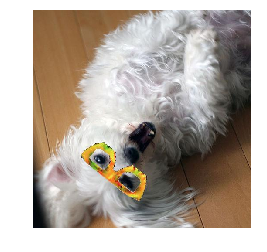

In [15]:
predict(path)